### Name: Sakir Kepezkaya 
### Martikelnummer: 568983
### WiSe 2023/24
### Seminar: Deep Learning
### Thema: Kreditkarten-Ausfallprognose durch Anwendung der Ensemble-Methoden Bagging und Boosting
### Das Skript besteht aus 4 Abschnitten: 1. Data Preparation, 2. Descriptive Analysis, 3. Hyperparameter Tuning, 4. Results 

### Packages

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics

## 1. Data Preparation 

In [117]:
warnings.filterwarnings("ignore")
os.getcwd()     
#os.chdir("/Users/SakirKepezkaya/Desktop/Seminar")
# load data
data = pd.read_excel("credit_default_data.xls", header=1)
# drop index column
data = data.drop(["ID"], axis=1)
# check for na values
data.isna().any()
#data = data.dropna() 
# separating features and target variable 
X = data.drop(["default payment next month"], axis=1)
y = data.filter(["default payment next month"])

## training & test data sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, 
  stratify = y, random_state=1)

## balanced training data w/ SMOTE
sm = SMOTE(random_state=7, sampling_strategy = 0.6)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

## 2. Descriptive Analysis

In [ ]:
pd.set_option("display.max_columns", None)
data.info()
data.head()
data.tail()
data.shape
data.describe()
data.mode()

### 2.1 Descriptive Analysis

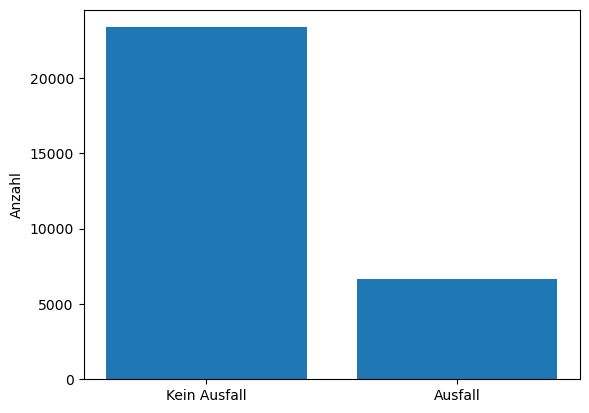

default ratio: 0.2212


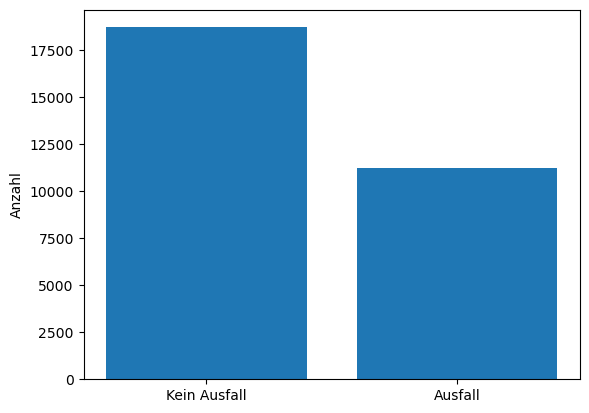

PAY_0
 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64

In [124]:
# visualizing the distribution of credit card default for unbalanced data 
value_counts = data["default payment next month"].value_counts()
labels = ["Kein Ausfall", "Ausfall"]
plt.bar(labels, value_counts.values)
plt.xticks(labels)
plt.ylabel("Anzahl")
#plt.title("Verteilung Kreditkarten-Ausfall im nächsten Monat")
plt.show()

## default ratio for unbalanced data
default_ratio = data["default payment next month"].value_counts()[1] / 30000
print("default ratio:", default_ratio)

# visualizing the distribution of credit card default for balanced data 
value_counts_sm = y_train_sm.value_counts()
labels = ["Kein Ausfall", "Ausfall"]
plt.bar(labels, value_counts_sm.values)
plt.xticks(labels)
plt.ylabel("Anzahl")
#plt.title("Verteilung Kreditkarten-Ausfall im nächsten Monat")
plt.show()


# count unknown values for payment status; 0 = unknown, -2 = unknown
PAY_0_count_all = data["PAY_0"].value_counts() 
PAY_2_count_all = data["PAY_2"].value_counts() 
PAY_3_count_all = data["PAY_3"].value_counts() 
PAY_4_count_all = data["PAY_4"].value_counts() 
PAY_5_count_all = data["PAY_5"].value_counts() 
PAY_6_count_all = data["PAY_6"].value_counts() 
PAY_0_count_all

### 2.2 Descriptive Analysis

In [21]:
# separating data into two subsets: w/o defaults and w/ defaults
no_default_data = data[data["default payment next month"] == 0]
default_data = data[data["default payment next month"] == 1]

#### boxplot for limit balance 

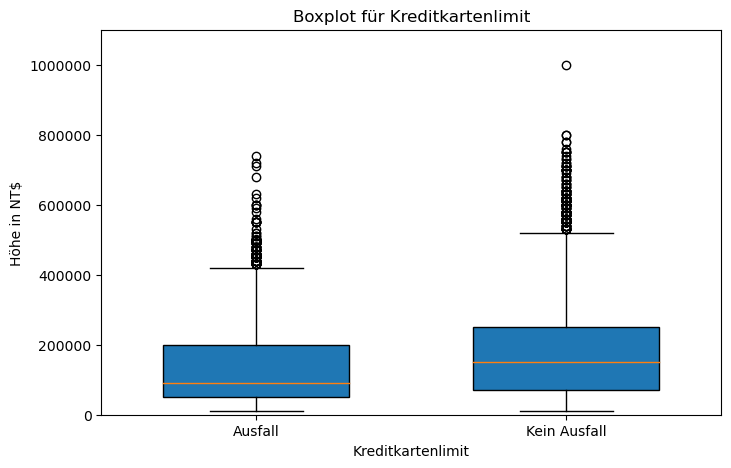

In [95]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(default_data["LIMIT_BAL"], positions=[1], widths=0.6, patch_artist=True)
ax.boxplot(no_default_data["LIMIT_BAL"], positions=[2], widths=0.6, patch_artist=True)
ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels(["{:.0f}".format(tick) for tick in ticks])
ax.set_ylim(0, 1100000)
# add labels and title
ax.set_xlabel("Kreditkartenlimit")
ax.set_ylabel("Höhe in NT$")
ax.set_title("Boxplot für Kreditkartenlimit")
ax.set_xticks([1, 2])
ax.set_xticklabels(["Ausfall", "Kein Ausfall"])
plt.show()

#### bar plot for sex grouped by default 

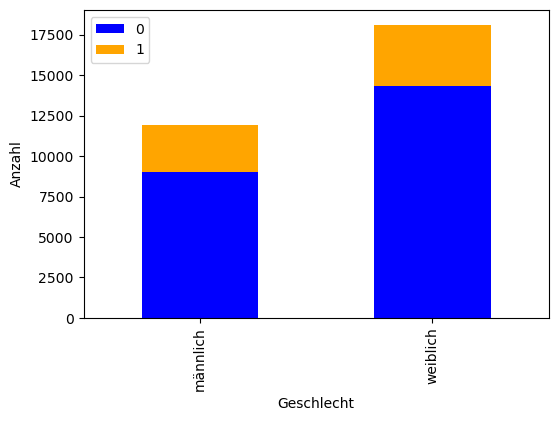

In [94]:
# separate data for defaults and no defaults based on gender
sex_1 = data[data["default payment next month"] == 1]["SEX"].value_counts()
sex_0 = data[data["default payment next month"] == 0]["SEX"].value_counts()
# combine and sort the data
sex_combined = pd.concat([sex_0, sex_1], axis=1, keys=["0", "1"])
sex_combined = sex_combined.sort_index()
sex_combined = sex_combined.rename(index={1: "männlich", 2: "weiblich"})
# create a stacked bar plot
fig, ax = plt.subplots(figsize=(6, 4))
sex_combined.plot(kind="bar", stacked=True, color=["blue", "orange"], ax=ax)
ax.set_xticklabels(sex_combined.index)
plt.xlabel("Geschlecht")
ax.set_ylabel("Anzahl")
plt.show()

#### bar plot for education grouped by default 

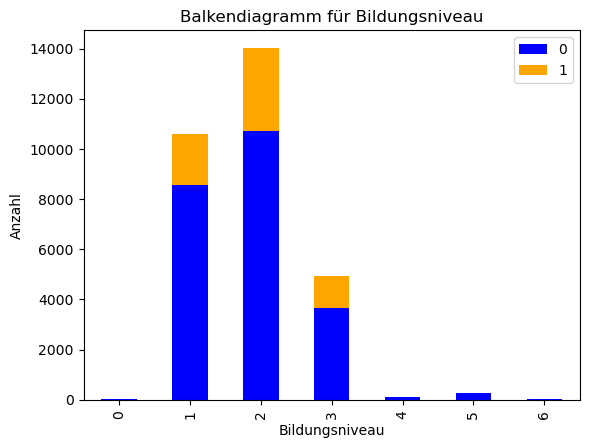

In [24]:
# separate data for defaults and no defaults based on education
education_1 = data[data["default payment next month"] == 1]["EDUCATION"].value_counts()
education_0 = data[data["default payment next month"] == 0]["EDUCATION"].value_counts()
# combine and sort the data
education_combined = pd.concat([education_0, education_1], axis=1, keys=["0", "1"])
education_combined = education_combined.sort_index()
# create a stacked bar plot
education_combined.plot(kind="bar", stacked=True, color=["blue", "orange"])
plt.xlabel("Bildungsniveau")
plt.ylabel("Anzahl")
plt.title("Balkendiagramm für Bildungsniveau")
plt.show()

#### bar plot for marriage grouped by default 

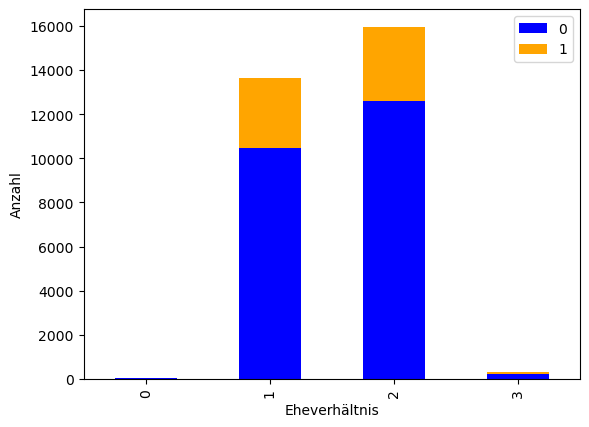

In [35]:
# separate data for defaults and no defaults based on marriage
marriage_1 = data[data["default payment next month"] == 1]["MARRIAGE"].value_counts()
marriage_0 = data[data["default payment next month"] == 0]["MARRIAGE"].value_counts()
marriage_combined = pd.concat([marriage_0, marriage_1], axis=1, keys=["0", "1"])
# create a stacked bar plot
marriage_combined = marriage_combined.sort_index()
marriage_combined.plot(kind="bar", stacked=True, color=["blue", "orange"])
plt.xlabel("Eheverhältnis")
plt.ylabel("Anzahl")
plt.show()

#### boxplot for the distribution of ages for default and no default 

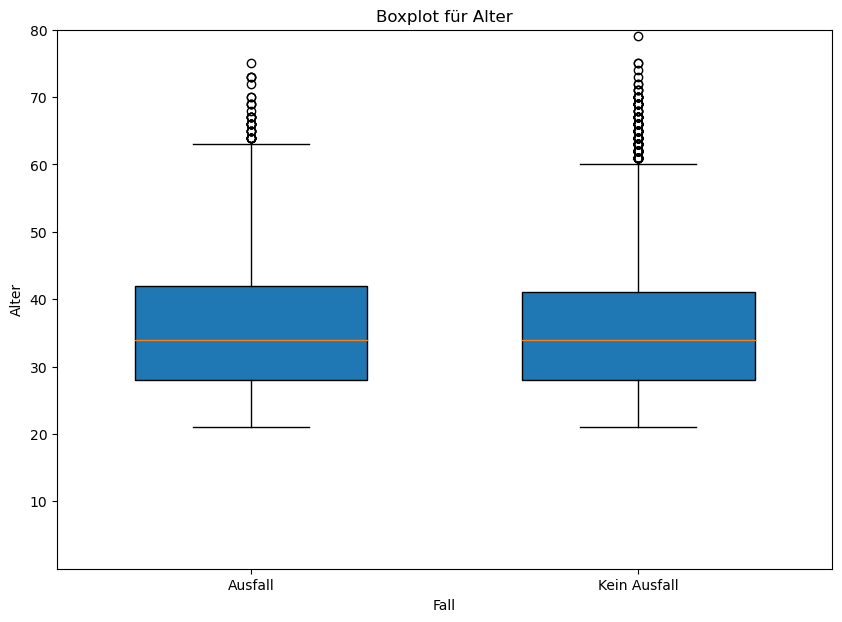

In [31]:
# create boxplots for default and no default data
fig, ax = plt.subplots(figsize=(10, 7))
ax.boxplot(default_data["AGE"], positions=[1], widths=0.6, patch_artist=True)
ax.boxplot(no_default_data["AGE"], positions=[2], widths=0.6, patch_artist=True)
ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels(["{:.0f}".format(tick) for tick in ticks])
ax.set_ylim(0, 80)
# add labels and title
ax.set_xlabel("Fall")
ax.set_ylabel("Alter")
ax.set_title("Boxplot für Alter")
ax.set_xticks([1, 2])
ax.set_xticklabels(["Ausfall", "Kein Ausfall"])
plt.show()

## 3. Hyperparameter Tuning
#### repeat for balanced data (change data sets)


### 3.1 Logistic Regression  

In [122]:
# create a Logistic Regression model
log_reg = LogisticRegression(random_state = 7, max_iter=1000)

# define parameter grid for grid search
param_grid_log = {"penalty":["l2"] , "C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# create GridSearchCV object
grid_search_log = GridSearchCV(estimator=log_reg, param_grid=param_grid_log, scoring="accuracy",  
                           cv = 3)

# fit grid search to the data
grid_search_log.fit(X_train, y_train.values.ravel())

# print the best parameters and the corresponding accuracy score
print("Best Parameters: ", grid_search_log.best_params_)

Best Parameters:  {'C': 0.001, 'penalty': 'l2'}


### 3.2 Bagging Classifier  

In [121]:
# create a Bagging Classifier model
bagging_model = BaggingClassifier(base_estimator = DecisionTreeClassifier())

# define parameter grid for grid search
param_grid_bag = {
    "n_estimators": [100, 200],
    "max_samples": [1.0, 0.8],
    "max_features": [1.0, 0.8],
    "base_estimator__max_depth": [1, 5, 10],  
    "base_estimator__min_samples_leaf": [1, 5, 10],  
    "random_state": [7]
}

# create GridSearchCV object
grid_search_bag = GridSearchCV(estimator=bagging_model, param_grid=param_grid_bag, scoring="accuracy", cv=3)

# fit grid search to the data
grid_search_bag.fit(X_train, y_train.values.ravel())

# print the best parameters
print("Best Parameters: ", grid_search_bag.best_params_)

Best Parameters:  {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 10, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 100, 'random_state': 7}


### 3.3 Boosting Classifier

In [120]:
# create a AdaBoost Classifier model
ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())

# create GridSearchCV object
param_grid_ada = {
    "n_estimators": [100, 200],
    "base_estimator__max_depth": [1, 5, 10],  
    "base_estimator__min_samples_leaf": [1, 5, 10],  
    "learning_rate": [0.01, 0.1, 0.5],
    "random_state": [7]
}

# create GridSearchCV object
grid_search_ada = GridSearchCV(estimator=ada, param_grid=param_grid_ada, scoring="accuracy", cv=3)

# fit grid search to the data
grid_search_ada.fit(X_train, y_train.values.ravel())

# print the best parameters
print("Best Parameters: ", grid_search_ada.best_params_)

Best Parameters:  {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 10, 'learning_rate': 0.01, 'n_estimators': 200, 'random_state': 7}


## 4. Results

### 4.1 Logistic Regression unbalanced data

In [47]:
# create best Logistic Regression model with unbalanced data
logreg_best = LogisticRegression(random_state=7, penalty="l2", C=0.001, max_iter=1000)
# fit the model with data
logreg_best.fit(X_train, y_train.values.ravel())
# predict test set y
y_pred = logreg_best.predict(X_test)

#### classification report

In [49]:
# test accuracy 
print("Logreg Model accuracy score: {:.4f}". format(accuracy_score(y_test, y_pred)))

# probabilties
prob_log_0 = logreg_best.predict_proba(X_test)[:,0]
prob_log_1 = logreg_best.predict_proba(X_test)[:,1]

# classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred))
class_names = ["Kein Ausfall", "Ausfall"]
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# classification report in data frame 
report_df = pd.DataFrame(report).transpose()
print(report_df)
# latex output for classification report
latex_table = report_df.to_latex()

Logreg Model accuracy score: 0.7785
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000

              precision    recall  f1-score    support
Kein Ausfall   0.778760  0.999572  0.875457  4673.0000
Ausfall        0.000000  0.000000  0.000000  1327.0000
accuracy       0.778500  0.778500  0.778500     0.7785
macro avg      0.389380  0.499786  0.437728  6000.0000
weighted avg   0.606524  0.778500  0.681835  6000.0000


#### ROC and AUC

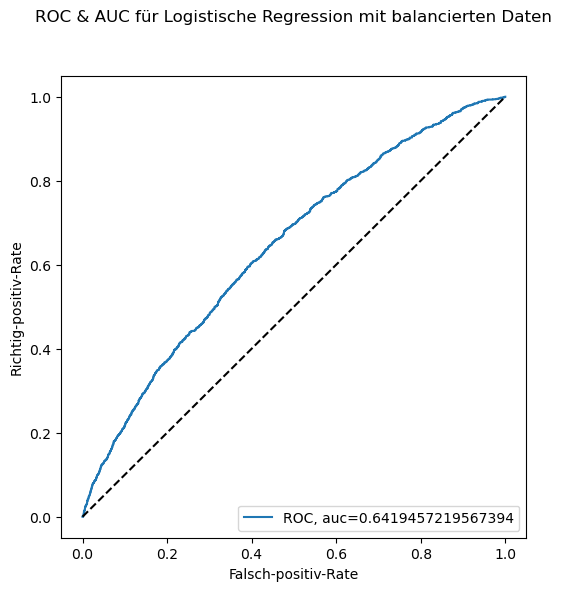

In [51]:
# AUC score 1 a perfect classifier, 0.5 represents a worthless classifier
plt.figure(figsize=(6, 6))
y_pred_proba = logreg_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], "k--", label="Wertloser Klassifikator")
plt.title("ROC & AUC für Logistische Regression mit balancierten Daten", y=1.1)
plt.xlabel("Falsch-positiv-Rate")
plt.ylabel("Richtig-positiv-Rate")
plt.show()

#### confusion matrix 

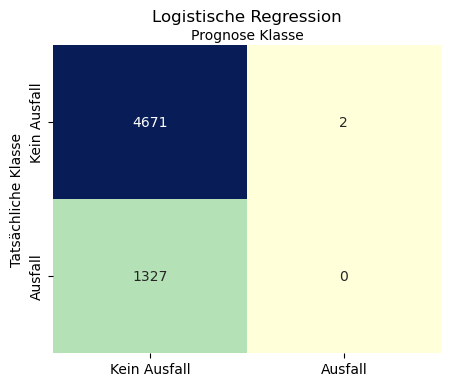

In [52]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# visualizing of confusion matrix 
class_names = ["Kein Ausfall", "Ausfall"]
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.xaxis.set_label_position("top")
plt.title("Logistische Regression",  y=1.05, fontsize=12)
plt.ylabel("Tatsächliche Klasse")
plt.xlabel("Prognose Klasse")  
plt.show()

#### feature importance

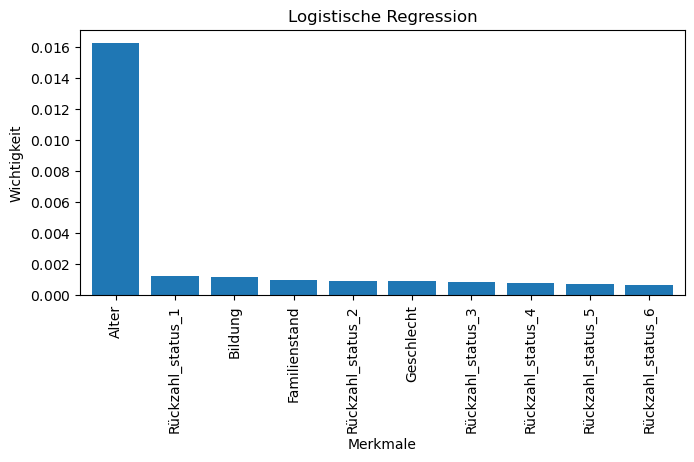

In [53]:
# rename features 
rename_dict = {"AGE": "Alter", "LIMIT_BAL": "Kreditkartenlimit", 
               "BILL_AMT1": "Ausgaben_1", "BILL_AMT2": "Ausgaben_2",
               "BILL_AMT3": "Ausgaben_3", "BILL_AMT4": "Ausgaben_4",
               "BILL_AMT5": "Ausgaben_5", "BILL_AMT6": "Ausgaben_6",
               "PAY_AMT1" : "Einkommen_1", "PAY_AMT2" : "Einkommen_2",
               "PAY_AMT3" : "Einkommen_3", "PAY_AMT4" : "Einkommen_4",
               "PAY_AMT5" : "Einkommen_5", "PAY_AMT6" : "Einkommen_6",
               "SEX" : "Geschlecht", "EDUCATION" : "Bildung",
               "MARRIAGE":"Familienstand","PAY_0": "Rückzahl_status_1",
               "PAY_2": "Rückzahl_status_2", "PAY_3": "Rückzahl_status_3",
               "PAY_4": "Rückzahl_status_4", "PAY_5": "Rückzahl_status_5",
               "PAY_6": "Rückzahl_status_6"}
coefficients = logreg_best.coef_[0]
importance_log = np.abs(coefficients)
# sort indicies 
indices = np.argsort(importance_log)[::-1]
# feature names
feature_names = X_train_sm.columns
new_labels = [rename_dict.get(old_name, old_name) for old_name in feature_names]
# visualization feature importance
fig, ax = plt.subplots(figsize=(7.8, 5))
ax.bar(range(X_train_sm.shape[1]), importance_log[indices])
ax.set_xticks(range(X_train_sm.shape[1]), [new_labels[i] for i in indices], rotation=90)
ax.set_xlabel("Merkmale")
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel("Wichtigkeit")
ax.set_title("Logistische Regression")
plt.subplots_adjust(bottom=0.35)
ax.set_xlim(-0.6, 9.6) 
plt.show()

### 4.2 Logistic Regression balanced data

In [55]:
# create best Logistic Regression model with balanced data
logreg_best = LogisticRegression(random_state=7, penalty="l2", C=0.1)
# fit the model with data
logreg_best.fit(X_train_sm, y_train_sm.values.ravel()) 
# predict test set y
y_pred = logreg_best.predict(X_test)

#### classification report

In [56]:
# test accuracy 
print("Logreg Model accuracy score: {:.4f}". format(accuracy_score(y_test, y_pred)))

# probabilties
prob_log_0 = logreg_best.predict_proba(X_test)[:,0]
prob_log_1 = logreg_best.predict_proba(X_test)[:,1]

# classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred))
class_names = ["Kein Ausfall", "Ausfall"]
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# classification report in data frame 
report_df = pd.DataFrame(report).transpose()
print(report_df)
# latex output for classification report
latex_table = report_df.to_latex()

Logreg Model accuracy score: 0.7813
              precision    recall  f1-score   support

           0       0.78      0.99      0.88      4673
           1       0.61      0.03      0.06      1327

    accuracy                           0.78      6000
   macro avg       0.70      0.51      0.47      6000
weighted avg       0.75      0.78      0.70      6000

              precision    recall  f1-score      support
Kein Ausfall   0.783246  0.994436  0.876296  4673.000000
Ausfall        0.611940  0.030897  0.058824  1327.000000
accuracy       0.781333  0.781333  0.781333     0.781333
macro avg      0.697593  0.512666  0.467560  6000.000000
weighted avg   0.745359  0.781333  0.695499  6000.000000


#### ROC and AUC

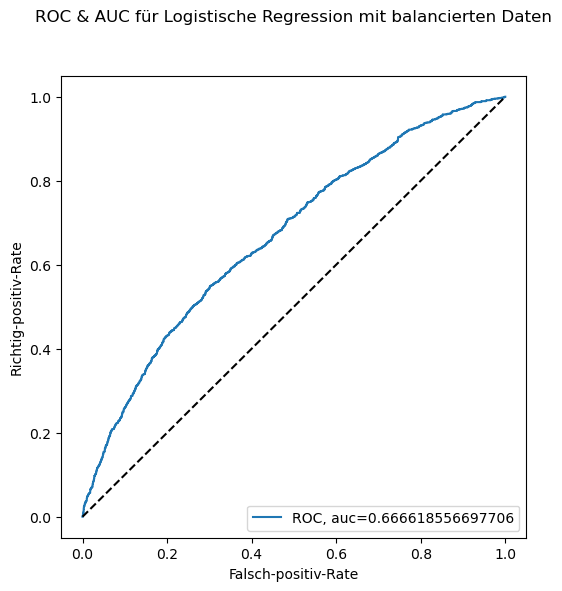

In [57]:
# AUC score 1 a perfect classifier, 0.5 represents a worthless classifier
plt.figure(figsize=(6, 6))
y_pred_proba = logreg_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], "k--", label="Wertloser Klassifikator")
plt.title("ROC & AUC für Logistische Regression mit balancierten Daten", y=1.1)
plt.xlabel("Falsch-positiv-Rate")
plt.ylabel("Richtig-positiv-Rate")
plt.show()

#### confusion matrix

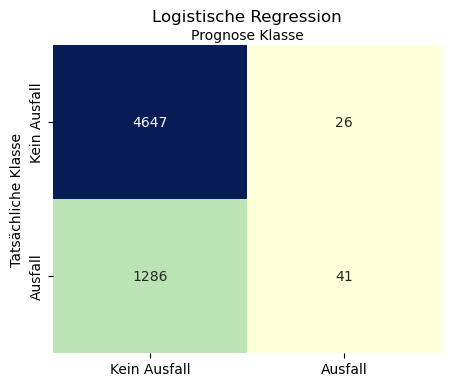

In [59]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# visualizing of confusion matrix 
class_names = ["Kein Ausfall", "Ausfall"]
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.xaxis.set_label_position("top")
plt.title("Logistische Regression",  y=1.05, fontsize=12)
plt.ylabel("Tatsächliche Klasse")
plt.xlabel("Prognose Klasse")  
plt.show()

#### feature importance

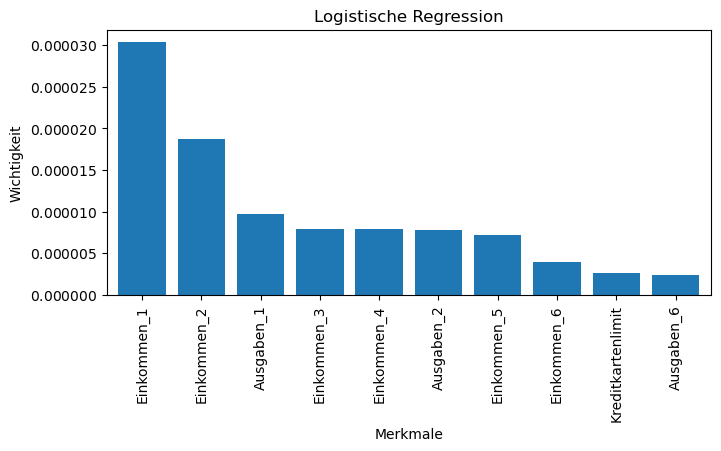

In [60]:
coefficients = logreg_best.coef_[0]
importance_log = np.abs(coefficients)
# sort indicies 
indices = np.argsort(importance_log)[::-1]
# feature names
feature_names = X_train_sm.columns
new_labels = [rename_dict.get(old_name, old_name) for old_name in feature_names]
# visualization feature importance
fig, ax = plt.subplots(figsize=(7.8, 5))
ax.bar(range(X_train_sm.shape[1]), importance_log[indices])
ax.set_xticks(range(X_train_sm.shape[1]), [new_labels[i] for i in indices], rotation=90)
ax.set_xlabel("Merkmale")
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel("Wichtigkeit")
ax.set_title("Logistische Regression")
plt.subplots_adjust(bottom=0.35)
ax.set_xlim(-0.6, 9.6) 
plt.show()

### 4.3 Bagging Classifier unbalanced data

In [63]:
# Instantiate  classification tree 
dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10, 
                            max_features= 0.8, random_state = 7)
# instantiate Bagging Classifier 
bag_best  = BaggingClassifier(estimator=dt, n_estimators=100,
                        oob_score = True,  random_state = 11)
# fit to training set
bag_best.fit(X_train, y_train.values.ravel())
# predict test set y
y_pred = bag_best.predict(X_test)

#### classification report

In [71]:
# test accuracy 
print("Bagging Model accuracy score: {:.4f}". format(accuracy_score(y_test, y_pred)))

# probabilties
prob_bag_0 = bag_best.predict_proba(X_test)[:,0]
prob_bag_1 = bag_best.predict_proba(X_test)[:,1]

# oob accuracy 
oob_accuracy = bag_best.oob_score_
print("oob_accuracy: {:.4f}".format(oob_accuracy))

## classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# classification report in data frame 
report_df = pd.DataFrame(report).transpose()
print(report_df)
# latex output for classification report
latex_table = report_df.to_latex()

Bagging Model accuracy score: 0.8198
oob_accuracy: 0.8210
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4673
           1       0.69      0.34      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000

              precision    recall  f1-score      support
Kein Ausfall   0.836582  0.955275  0.891997  4673.000000
Ausfall        0.685241  0.342879  0.457057  1327.000000
accuracy       0.819833  0.819833  0.819833     0.819833
macro avg      0.760911  0.649077  0.674527  6000.000000
weighted avg   0.803110  0.819833  0.795803  6000.000000


#### ROC and AUC

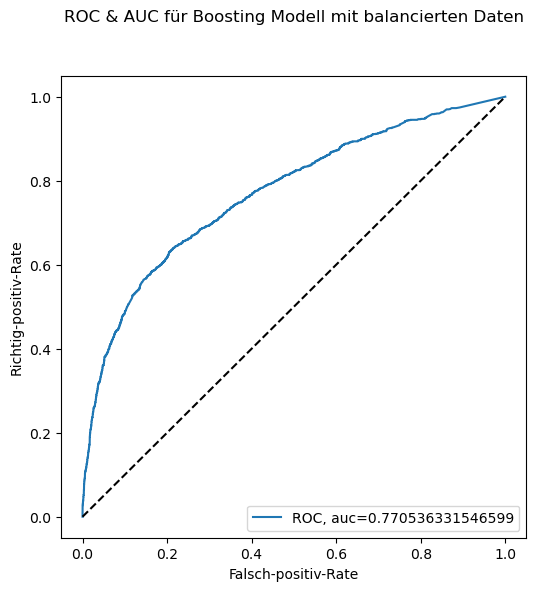

In [72]:
# AUC score 1 a perfect classifier, 0.5 represents a worthless classifier
plt.figure(figsize=(6, 6))
y_pred_proba = bag_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# visualizing of ROC
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], "k--", label="Wertloser Klassifikator")
plt.title("ROC & AUC für Boosting Modell mit balancierten Daten", y=1.1)
plt.xlabel("Falsch-positiv-Rate")
plt.ylabel("Richtig-positiv-Rate")
plt.show()

#### confusion matrix 

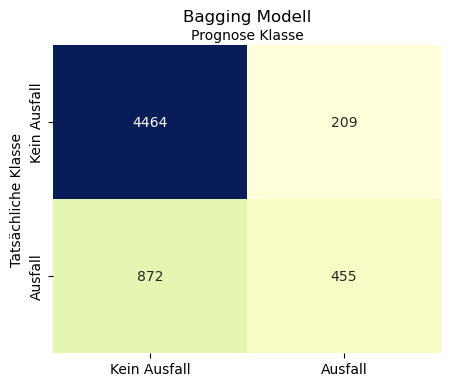

In [73]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# visualizing of confusion matrix 
class_names = ["Kein Ausfall", "Ausfall"]
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.xaxis.set_label_position("top")
plt.title("Bagging Modell", y=1.05, fontsize=12)
plt.ylabel("Tatsächliche Klasse")
plt.xlabel("Prognose Klasse")  
plt.show()

#### feature importance

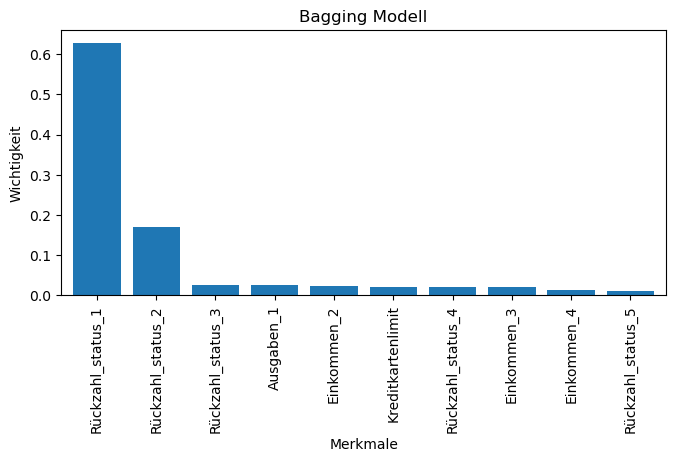

In [74]:
importances_bag = np.mean([
tree.feature_importances_ for tree in bag_best
], axis=0)
# sort indicies 
indices = np.argsort(importances_bag)[::-1]
# feature names
feature_names = X_train_sm.columns
new_labels = [rename_dict.get(old_name, old_name) for old_name in feature_names]
# visualization feature importance
fig, ax = plt.subplots(figsize=(7.8, 5))
ax.bar(range(X_train_sm.shape[1]), importances_bag[indices])
ax.set_xticks(range(X_train_sm.shape[1]), [new_labels[i] for i in indices], rotation=90)
ax.set_xlabel("Merkmale")
ax.set_ylabel("Wichtigkeit")
ax.set_title("Bagging Modell")
plt.subplots_adjust(bottom=0.35)
ax.set_xlim(-0.6, 9.6) 
plt.show()

### 4.4 Bagging Classifier balanced data

In [77]:
# instantiate classification tree 
dt = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 1, 
                            max_features= 0.8, random_state = 7)
# instantiate Bagging Classifier 
bag_best  = BaggingClassifier(estimator=dt, n_estimators=200,
                        oob_score = True, random_state = 6)
# fit to training set
bag_best.fit(X_train_sm, y_train_sm.values.ravel())
# predict test set y
y_pred = bag_best.predict(X_test)

#### classification report

In [80]:
# test accuracy 
print("Bagging Model accuracy score: {:.4f}". format(accuracy_score(y_test, y_pred)))

# probabilties
prob_bag_0 = bag_best.predict_proba(X_test)[:,0]
prob_bag_1 = bag_best.predict_proba(X_test)[:,1]

# oob accuracy 
oob_accuracy = bag_best.oob_score_
print("oob_accuracy: {:.4f}".format(oob_accuracy))

## classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# classification report in data frame 
report_df = pd.DataFrame(report).transpose()
print(report_df)
# latex output for classification report
latex_table = report_df.to_latex()

Bagging Model accuracy score: 0.8062
oob_accuracy: 0.7839
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.58      0.45      0.51      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.69      6000
weighted avg       0.79      0.81      0.80      6000

              precision    recall  f1-score      support
Kein Ausfall   0.852693  0.907982  0.879469  4673.000000
Ausfall        0.580078  0.447626  0.505317  1327.000000
accuracy       0.806167  0.806167  0.806167     0.806167
macro avg      0.716386  0.677804  0.692393  6000.000000
weighted avg   0.792400  0.806167  0.796719  6000.000000


#### ROC and AUC

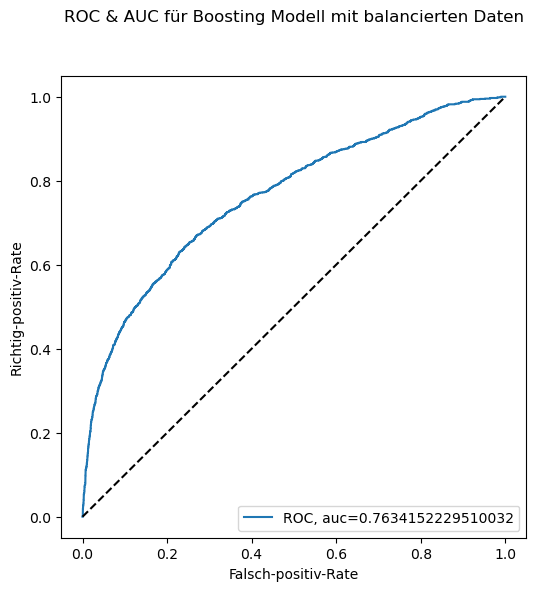

In [81]:
# AUC score 1 a perfect classifier, 0.5 represents a worthless classifier
plt.figure(figsize=(6, 6))
y_pred_proba = bag_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# visualizing of ROC
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], "k--", label="Wertloser Klassifikator")
plt.title("ROC & AUC für Boosting Modell mit balancierten Daten", y=1.1)
plt.xlabel("Falsch-positiv-Rate")
plt.ylabel("Richtig-positiv-Rate")
plt.show()

#### confusion matrix

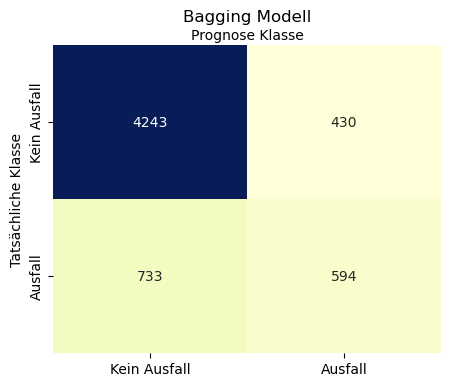

In [82]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# visualizing of confusion matrix 
class_names = ["Kein Ausfall", "Ausfall"]
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.xaxis.set_label_position("top")
plt.title("Bagging Modell", y=1.05, fontsize=12)
plt.ylabel("Tatsächliche Klasse")
plt.xlabel("Prognose Klasse")  
plt.show()

#### feature importance

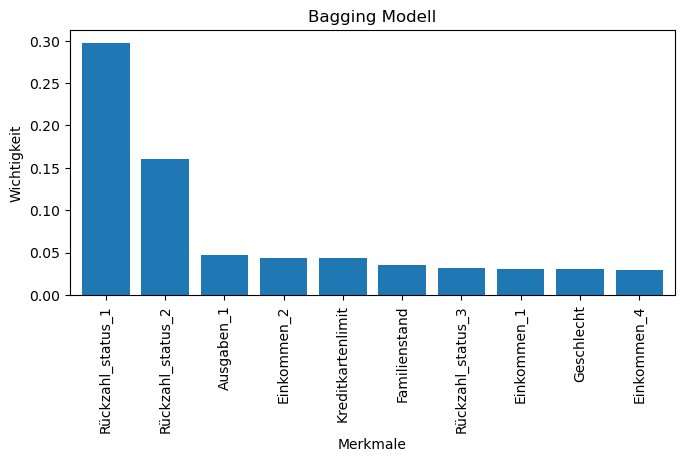

In [83]:
importances_bag = np.mean([
tree.feature_importances_ for tree in bag_best
], axis=0)
# sort indicies 
indices = np.argsort(importances_bag)[::-1]
# feature names
feature_names = X_train_sm.columns
new_labels = [rename_dict.get(old_name, old_name) for old_name in feature_names]
# visualization feature importance
fig, ax = plt.subplots(figsize=(7.8, 5))
ax.bar(range(X_train_sm.shape[1]), importances_bag[indices])
ax.set_xticks(range(X_train_sm.shape[1]), [new_labels[i] for i in indices], rotation=90)
ax.set_xlabel("Merkmale")
ax.set_ylabel("Wichtigkeit")
ax.set_title("Bagging Modell")
plt.subplots_adjust(bottom=0.35)
ax.set_xlim(-0.6, 9.6) 
plt.show()


### 4.5 Boosting Classifier unbalanced data

In [84]:
# instantiate  classification tree 
dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf= 10, random_state=7)
# Instantiate AdaBoost Classifier
ada_best = AdaBoostClassifier(estimator=dt, n_estimators=200, 
                              learning_rate= 0.01, random_state = 6)
# Fit to the training set
ada_best.fit(X_train, y_train.values.ravel())
# predict test set y
y_pred = ada_best.predict(X_test)

#### classification report

In [85]:
# test accuracy 
print("Boosting Model accuracy score: {:.4f}". format(accuracy_score(y_test, y_pred)))

#  probabilties
prob_ada_0 = ada_best.predict_proba(X_test)[:,0]
prob_ada_1 = ada_best.predict_proba(X_test)[:,1]

## classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# classification report in data frame 
report_df = pd.DataFrame(report).transpose()
print(report_df)
# latex output for classification report
latex_table = report_df.to_latex()  

Boosting Model accuracy score: 0.8210
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.69      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

              precision    recall  f1-score   support
Kein Ausfall   0.837934  0.954847  0.892579  4673.000
Ausfall        0.687407  0.349661  0.463536  1327.000
accuracy       0.821000  0.821000  0.821000     0.821
macro avg      0.762671  0.652254  0.678057  6000.000
weighted avg   0.804643  0.821000  0.797689  6000.000


#### ROC and AUC

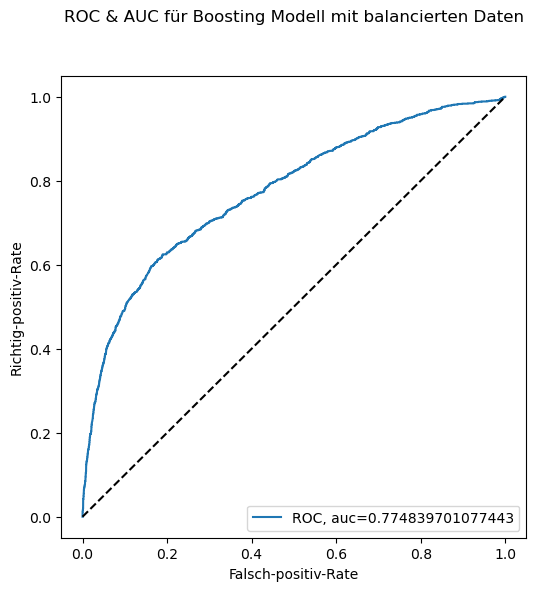

In [86]:
# AUC score 1 a perfect classifier, 0.5 represents a worthless classifier
plt.figure(figsize=(6, 6))
y_pred_proba = ada_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# visualizing of ROC
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], "k--", label="Wertloser Klassifikator")
plt.title("ROC & AUC für Boosting Modell mit balancierten Daten", y=1.1)
plt.xlabel("Falsch-positiv-Rate")
plt.ylabel("Richtig-positiv-Rate")
plt.show()

#### confusion matrix

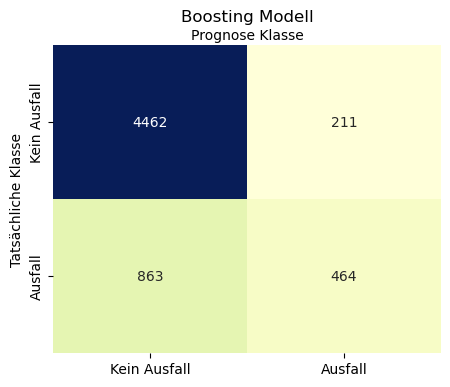

In [87]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = ["Kein Ausfall", "Ausfall"]
# visualizing of confusion matrix 
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.xaxis.set_label_position("top")
plt.title("Boosting Modell", y=1.05, fontsize=12)
plt.ylabel("Tatsächliche Klasse")
plt.xlabel("Prognose Klasse")  
plt.show()

#### feature importance

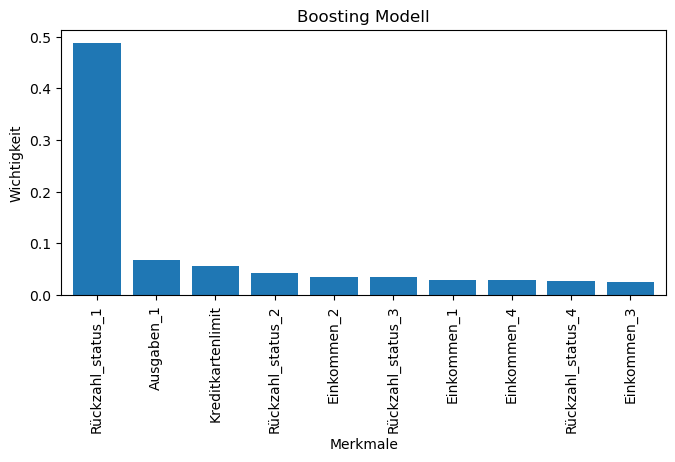

In [88]:
importances = ada_best.feature_importances_
# sort indicies 
indices = np.argsort(importances)[::-1]
# feature names
feature_names = X_train_sm.columns
new_labels = [rename_dict.get(old_name, old_name) for old_name in feature_names[indices]]
# visualization feature importance
fig, ax = plt.subplots(figsize=(7.8, 5))
ax.bar(range(X_train_sm.shape[1]), importances[indices])
ax.set_xticks(range(X_train_sm.shape[1]))
ax.set_xticklabels(new_labels, rotation=90)
ax.set_xlabel("Merkmale")
ax.set_ylabel("Wichtigkeit")
ax.set_title("Boosting Modell")
plt.subplots_adjust(bottom=0.35)
ax.set_xlim(-0.6, 9.6) 
plt.show()

### 4.6 Boosting Modell balanced data

In [89]:
# instantiate  classification tree 
dt = DecisionTreeClassifier(max_depth = 10, min_samples_leaf= 1, random_state=7)
# Instantiate ada
ada_best = AdaBoostClassifier(estimator=dt, n_estimators=200, 
                              learning_rate= 0.1, random_state = 6)  
# Fit ada to the training set
ada_best.fit(X_train_sm, y_train_sm.values.ravel())
# predict test set y
y_pred = ada_best.predict(X_test)

#### classification report

In [90]:
# test accuracy 
print("Boosting Model accuracy score: {:.4f}". format(accuracy_score(y_test, y_pred)))

#  probabilties
prob_ada_0 = ada_best.predict_proba(X_test)[:,0]
prob_ada_1 = ada_best.predict_proba(X_test)[:,1]

## classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# classification report in data frame 
report_df = pd.DataFrame(report).transpose()
print(report_df)
# latex output for classification report
latex_table = report_df.to_latex()  

Boosting Model accuracy score: 0.7925
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4673
           1       0.54      0.42      0.47      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.66      0.67      6000
weighted avg       0.78      0.79      0.78      6000

              precision    recall  f1-score    support
Kein Ausfall   0.844177  0.899636  0.871025  4673.0000
Ausfall        0.540196  0.415222  0.469536  1327.0000
accuracy       0.792500  0.792500  0.792500     0.7925
macro avg      0.692186  0.657429  0.670280  6000.0000
weighted avg   0.776946  0.792500  0.782229  6000.0000


#### ROC and AUC

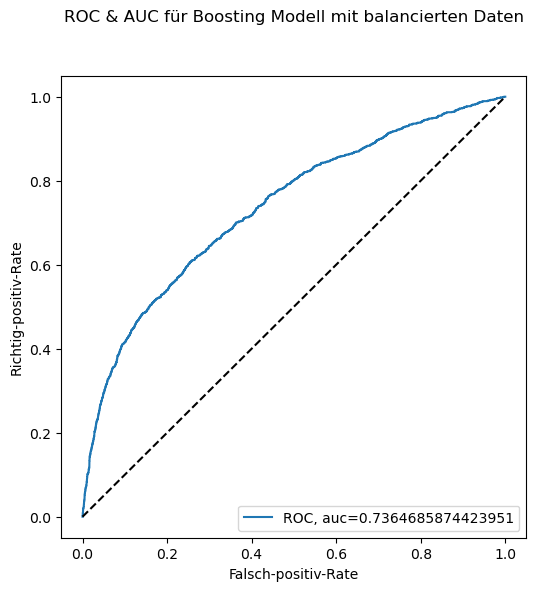

In [91]:
# AUC score 1 a perfect classifier, 0.5 represents a worthless classifier
plt.figure(figsize=(6, 6))
y_pred_proba = ada_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# visualizing of ROC
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], "k--", label="Wertloser Klassifikator")
plt.title("ROC & AUC für Boosting Modell mit balancierten Daten", y=1.1)
plt.xlabel("Falsch-positiv-Rate")
plt.ylabel("Richtig-positiv-Rate")
plt.show()

#### confusion matrix

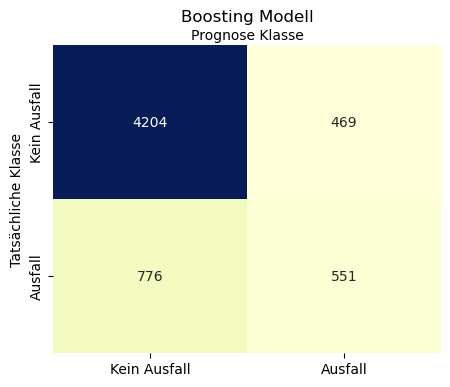

In [92]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = ["Kein Ausfall", "Ausfall"]
# visualizing of confusion matrix 
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.xaxis.set_label_position("top")
plt.title("Boosting Modell", y=1.05, fontsize=12)
plt.ylabel("Tatsächliche Klasse")
plt.xlabel("Prognose Klasse")  
plt.show()

#### feature importance

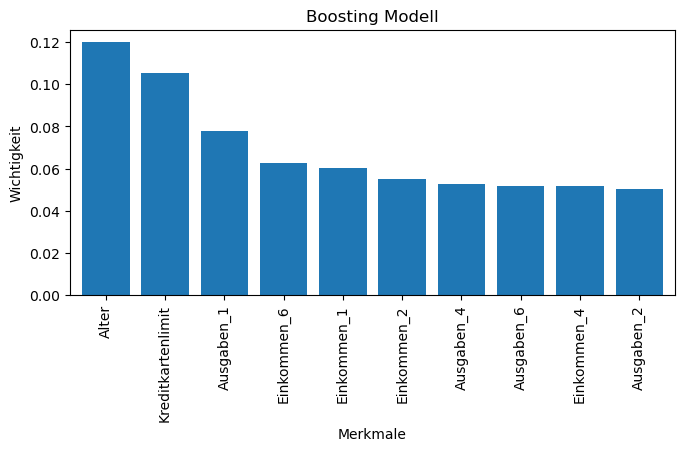

In [93]:
importances = ada_best.feature_importances_
# sort indicies 
indices = np.argsort(importances)[::-1]
# feature names
feature_names = X_train_sm.columns
new_labels = [rename_dict.get(old_name, old_name) for old_name in feature_names[indices]]
# visualization feature importance
fig, ax = plt.subplots(figsize=(7.8, 5))
ax.bar(range(X_train_sm.shape[1]), importances[indices])
ax.set_xticks(range(X_train_sm.shape[1]))
ax.set_xticklabels(new_labels, rotation=90)
ax.set_xlabel("Merkmale")
ax.set_ylabel("Wichtigkeit")
ax.set_title("Boosting Modell")
plt.subplots_adjust(bottom=0.35)
ax.set_xlim(-0.6, 9.6) 
plt.show()